In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
from scipy.spatial.distance import cdist

import anndata as ad
import pandas as pd
import sys

module_pth = "/home/alma/w-projects/ccf/src"
if module_pth not in sys.path:
    sys.path.append(module_pth)
    

import preprocess as pp

import os.path as osp
import os
from PIL import Image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from matplotlib import rcParams
rcParams["figure.facecolor"] = "white"

In [6]:
TRI_REF_DIR = "/home/alma/w-projects/ccf/rsc/ref/tri"
TRI_CNT_DIR = "/home/alma/w-projects/ccf/data/ludlar-triangle/curated"

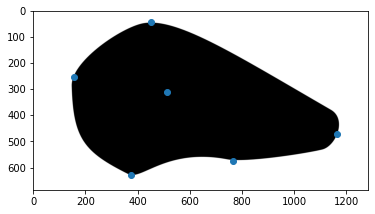

In [7]:
ref_img = Image.open(osp.join(TRI_REF_DIR,"tri.png"))
ref_lmk = pd.read_csv(osp.join(TRI_REF_DIR,"tri_reference_landmarks.tsv"),sep="\t",header = 0,index_col=0)

plt.imshow(ref_img)
plt.scatter(ref_lmk.x_cord,ref_lmk.y_cord)


In [8]:
grid_crd = pp.reference_to_grid(ref_img,n_approx_points=1000)

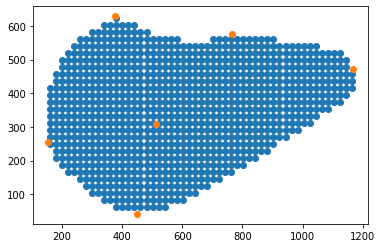

In [9]:
plt.scatter(grid_crd[:,0],grid_crd[:,1])
plt.scatter(ref_lmk.x_cord,ref_lmk.y_cord)


In [10]:
mx_grid = grid_crd.max()
grid_crd = grid_crd / mx_grid
ref_lmk.iloc[:,:] = ref_lmk.iloc[:,:] / mx_grid

/home/alma/.local/lib/python3.7/site-packages/pandas/compat/_optional.py:123: UserWarning: Pandas requires version '2.6.8' or newer of 'numexpr' (version '2.6.6' currently installed).
  warnings.warn(msg, UserWarning)


In [62]:
pths = os.listdir(TRI_CNT_DIR)
adatas = [ad.read_h5ad(osp.join(TRI_CNT_DIR,p)) for p in pths]

In [63]:
sc.pp.filter_genes(adata,min_cells = 0.1)
#pp.normalize_jointly(adatas)
for adata in adatas:
    sc.pp.normalize_total(adata,1e4,exclude_highly_expressed = True)
    sc.pp.log1p(adata,)
    sc.pp.scale(adata)
    pp.match_scales(adata,ref_lmk.values)
    pp.get_landmark_distance(adata)




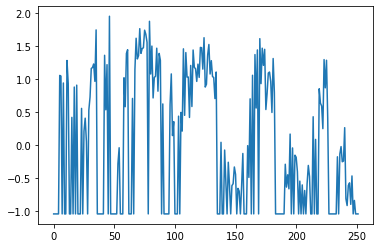

In [64]:
plt.plot(adata.obs_vector("CCN2"))

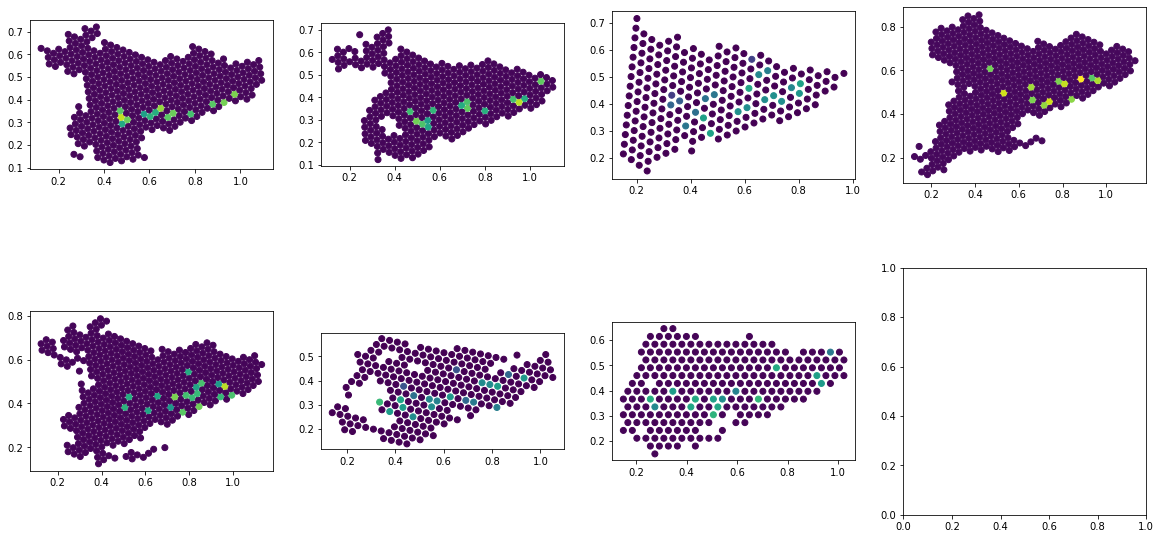

In [80]:
gene = "COL2A1"
fig,ax = plt.subplots(2,4,figsize = (20,10))
ax = ax.flatten()
mn = min([a.obs_vector(gene).min() for a in adatas])
mx = max([a.obs_vector(gene).max() for a in adatas])
for k,adata in enumerate(adatas):
    ax[k].scatter(adata.obsm["spatial"][:,0],
                adata.obsm["spatial"][:,1],
                  vmin = mn,
                  vmax = mx,
                c = adata.obs_vector(gene))
    ax[k].set_aspect("equal")


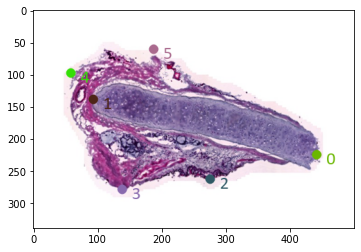

In [86]:
plt.imshow(adatas[-1].uns["spatial"]["section_1"]["images"]["hires_landmarks"])

In [81]:
import models as m
import methods as f
ref = m.Reference(grid_crd,
                  landmarks = ref_lmk.values,
                 )

models = f.map_to_reference(adatas,
                           gene,
                            ref,
                            n_epochs=1000,
                           )

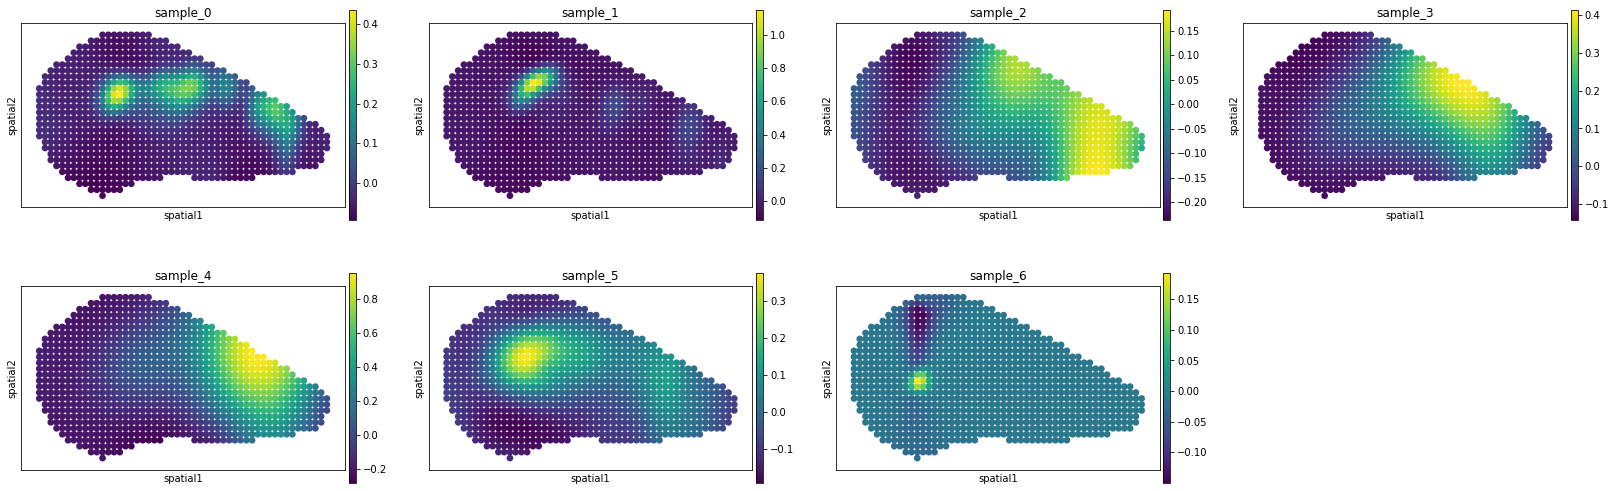

In [87]:
ref.plot(spot_size=0.02)#,ncols = 5)

In [68]:
crd_1,expr_1 = ref.get_sample(0)
crd_2,expr_2 = ref.get_sample(4)

In [69]:
np.sum(expr_1 < 0)

561

In [70]:
lfc2 = np.log2((np.exp(expr_1) / (np.exp(expr_2))))

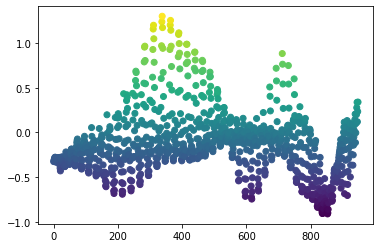

In [71]:
plt.scatter(np.arange(len(lfc2)),lfc2,c=lfc2)

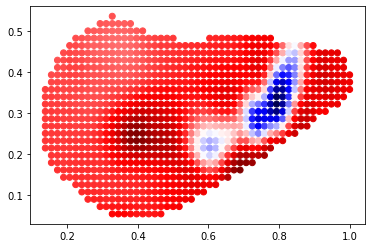

In [45]:
plt.scatter(crd_1[:,0],crd_1[:,1],c= lfc2,cmap = plt.cm.seismic)

In [ ]:
adatas[0].obs_vector("CNN2")